# HW4

## Template Notebook

In [76]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

In [26]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [27]:
%%sql sqlite:///data.db

SELECT * FROM ohlc WHERE token='BTC' LIMIT 5

Done.


ts,open,high,low,close,volume,volumeUSD,token,chain
2021-11-01 00:00:00,61421.37,61669.14,61239.6,61343.68,256.43386884,15757506.49252652,BTC,BTC
2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.48118498,20445578.51330501,BTC,BTC
2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.25071995,19353904.091577783,BTC,BTC
2021-11-01 03:00:00,61333.17,61457.28,60050.0,60589.06,1059.93135838,64146246.7043883,BTC,BTC
2021-11-01 04:00:00,60590.23,60655.0,59752.92,59971.89,621.41987775,37447441.40394106,BTC,BTC


## data.db file

In [28]:
conn = sqlite3.connect('data.db')
cur = conn.cursor()

In [29]:
for row in cur.execute('SELECT name FROM sqlite_master'):
    print(row)

('ohlc',)
('market_caps',)


In [30]:
for row in cur.execute('SELECT sql FROM sqlite_master'):
    print(row)

('CREATE TABLE "ohlc" (\n"ts" TIMESTAMP,\n  "open" REAL,\n  "high" REAL,\n  "low" REAL,\n  "close" REAL,\n  "volume" REAL,\n  "volumeUSD" REAL,\n  "token" TEXT,\n  "chain" TEXT\n)',)
('CREATE TABLE market_caps (\n\t"Rank" BIGINT, \n\t"Name" TEXT, \n\t"Symbol" TEXT, \n\t"MarketCap" FLOAT, \n\t"Price" FLOAT, \n\t"VolumeUSD" FLOAT\n)',)


In [31]:
%%sql sqlite:///data.db

SELECT Distinct token FROM ohlc

Done.


token
BTC
ETH
USDT
SOL
ADA
DOT
AVAX
ATOM
CRV
AAVE


In [34]:
tokens = pd.read_sql("SELECT Distinct token FROM ohlc", conn)
s = tokens.squeeze()
s

0      BTC
1      ETH
2     USDT
3      SOL
4      ADA
5      DOT
6     AVAX
7     ATOM
8      CRV
9     AAVE
10    COMP
Name: token, dtype: object

In [35]:
%%sql sqlite:///data.db

SELECT * FROM market_caps LIMIT 5

Done.


Rank,Name,Symbol,MarketCap,Price,VolumeUSD
1,Bitcoin,BTC,932695365142.0,49368.85,37198201161.0
2,Ethereum,ETH,498007875686.0,4198.32,25533062707.0
3,Binance Coin,BNB,93038857104.0,557.78,2394235567.0
4,Tether,USDT,75159692181.0,1.0,82054153191.0
5,Solana,SOL,59983315118.0,196.17,3402591975.0


In [52]:
token = 'BTC'
from_date = '2021-11-01'
to_date = '2021-11-05'
connection_string = 'sqlite:///data.db'
#events_db = 'crypto_events_database'

In [53]:
prices = pd.read_sql(f"SELECT * FROM ohlc WHERE token='{token}' AND ts >= '{from_date}'AND ts >= '{from_date}' AND ts < '{to_date}'", conn)

In [54]:
prices['ts'] = pd.to_datetime(prices['ts'])
prices.set_index('ts', inplace=True)

In [77]:
def vol_ohlc(df, lookback=10):
    o=df.open
    h=df.high
    c=df.close
    l=df.low
    
    k=0.34 / (1.34 + (lookback + 1) / (lookback-1))
    
    cc=np.log(c/c.shift(1))
    ho=np.log(h/o)
    lo=np.log(l/o)
    co=np.log(c/o)
    oc=np.log(o/c.shift(1))
    oc_sqr=oc**2
    cc_sqr=cc**2
    
    rs= ho*(ho - co) + lo*(lo - co)
    close_vol = cc_sqr.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sqr.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    
    result[:lookback -1] = np.nan
    
    return result

In [56]:
prices['volatility'] = vol_ohlc(prices)

In [57]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,volatility
ts,,,,,,,,,
2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC,NaN
2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC,NaN
2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC,NaN
2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC,NaN
2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC,NaN
...,...,...,...,...,...,...,...,...,...
2021-11-04 19:00:00,60909.47,61425.00,60754.90,60790.97,620.358241,3.792312e+07,BTC,BTC,0.112226
2021-11-04 20:00:00,60790.96,61321.96,60728.77,61260.90,616.041634,3.761622e+07,BTC,BTC,0.110874
2021-11-04 21:00:00,61271.30,61574.94,61097.56,61370.71,384.366947,2.356648e+07,BTC,BTC,0.112220


In [58]:
prices['hourly_return'] = prices['high']-prices['low']

In [81]:
def max_drawdown(price):
    return (np.maximum.accumulate(price) - price) / np.maximum.accumulate(price)

In [82]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [83]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-12'
connection_string = 'sqlite:///data.db'

In [85]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [86]:
prices['return'] = prices[['close']].pct_change()

In [87]:
prices['volatility'] = vol_ohlc(prices)

In [88]:
prices['max_drawdown'] = max_drawdown(prices.close)

In [89]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

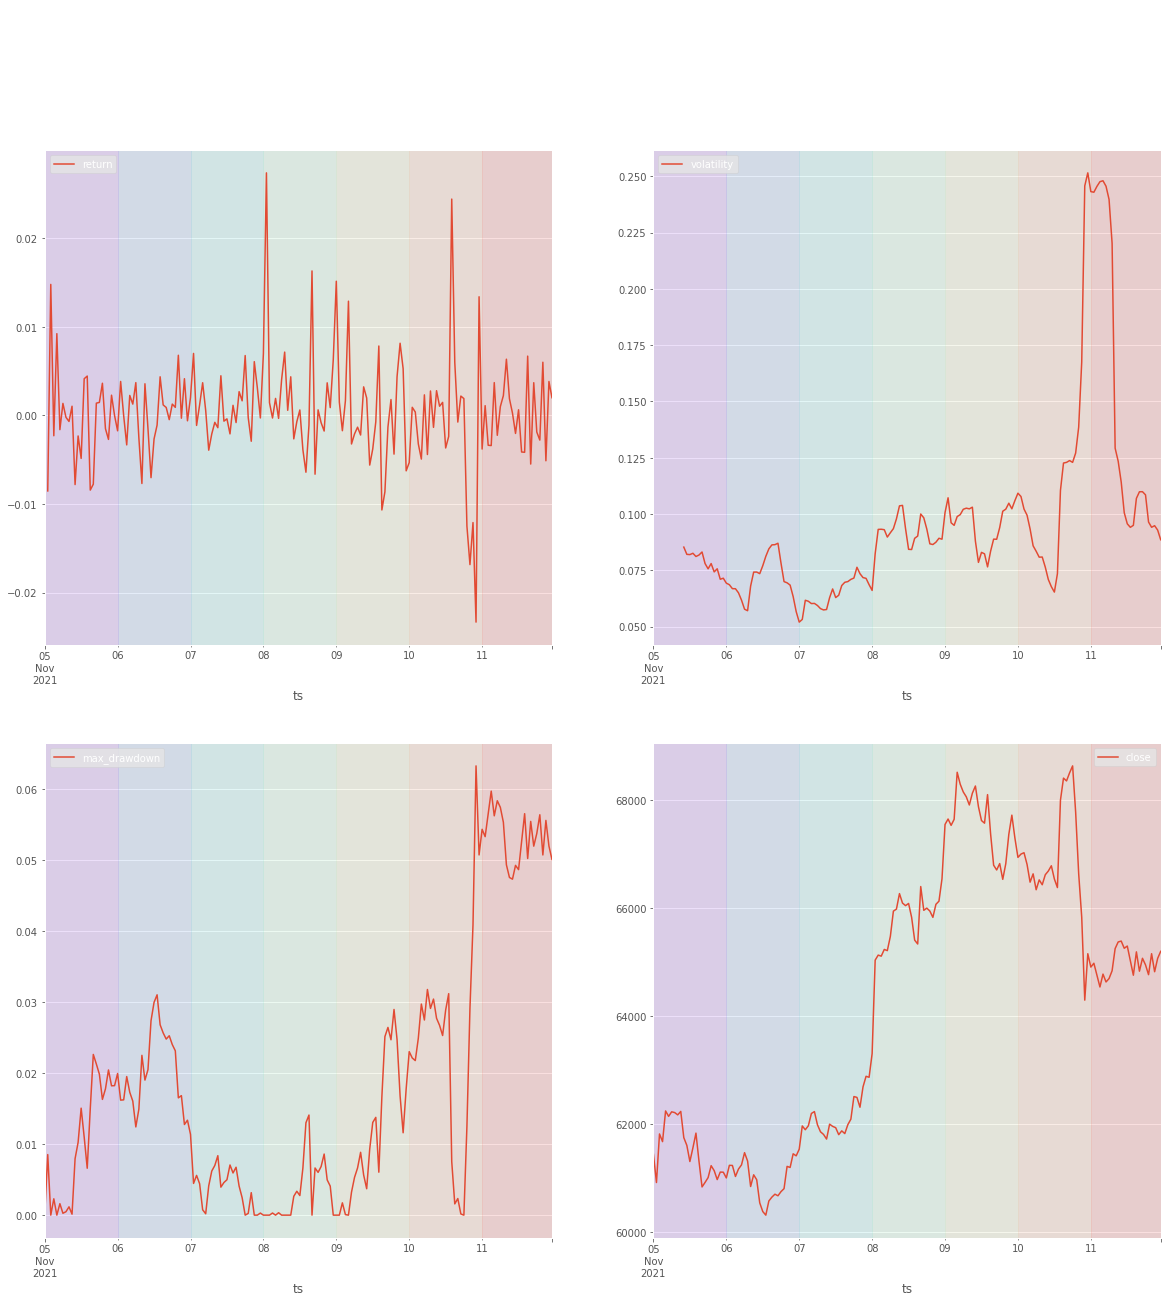

In [90]:
series_plot(prices[['return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['max_drawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

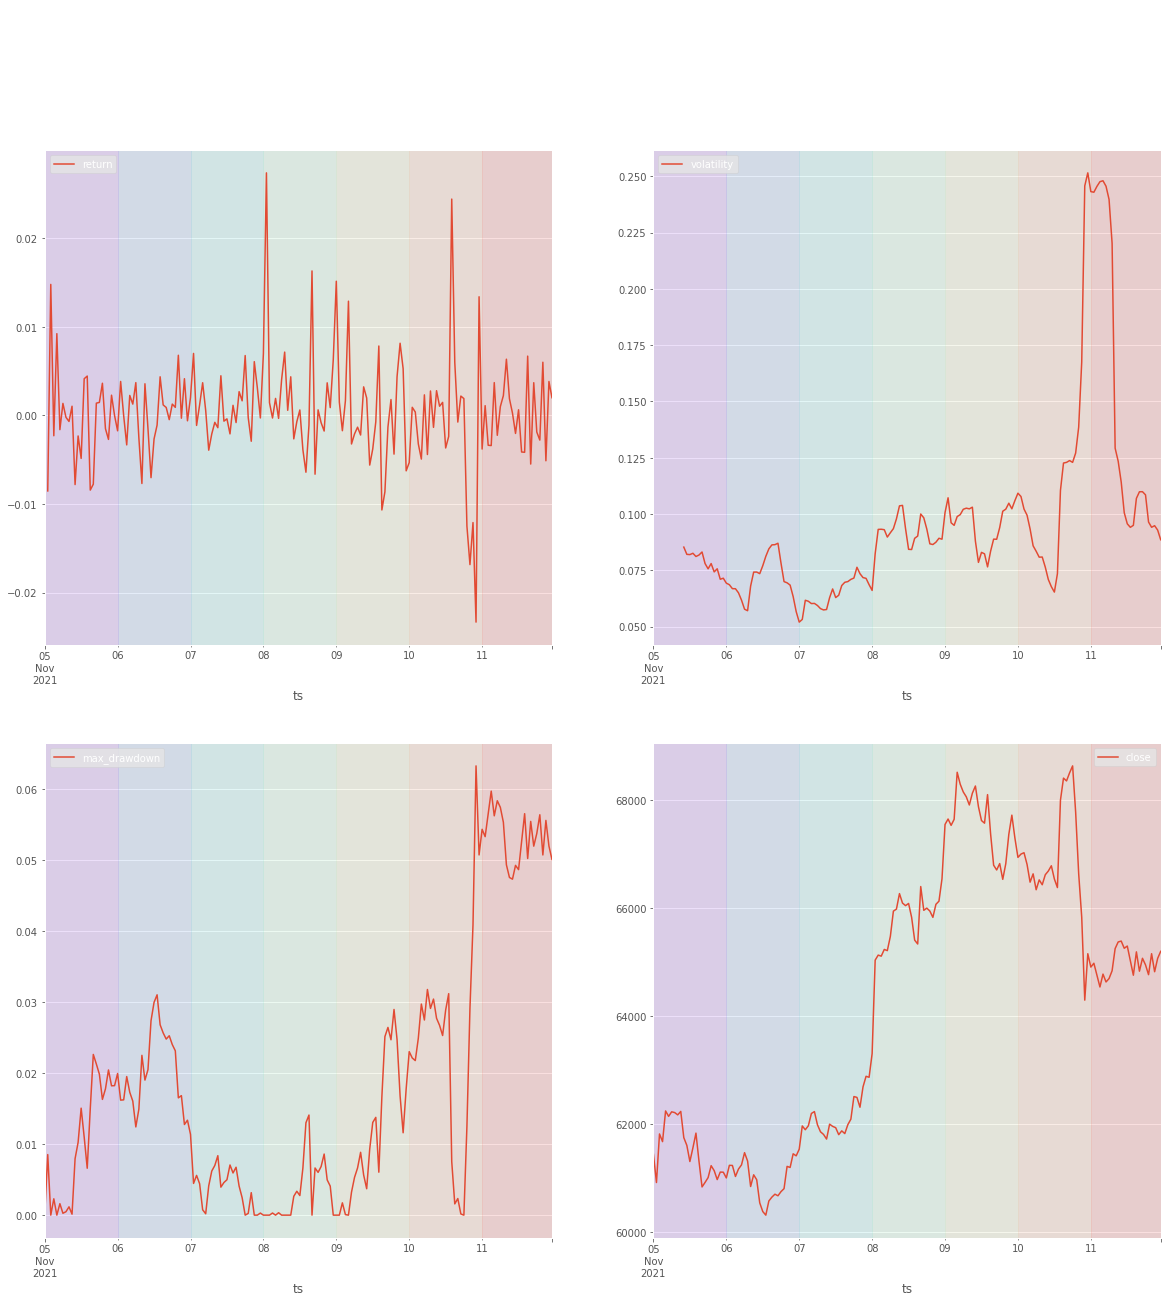

In [91]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)